In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# Connect to SQL DB
conn = sqlite3.connect('../sql_db/test_db.db') 

# SQL query to join all tables on 'patient_id'
query = """
SELECT * 
FROM tHealthStatus hs
JOIN tPatients p ON hs.patient_id = p.patient_id
JOIN tDisabilities d ON hs.patient_id = d.patient_id
JOIN tLifestyle l ON hs.patient_id = l.patient_id
JOIN tMedicalTests mt ON hs.patient_id = mt.patient_id
"""

# Load the data into a DataFrame
df = pd.read_sql_query(query, conn)

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,patient_id,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,patient_id,State,Sex,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,patient_id,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,patient_id,SmokerStatus,ECigaretteUsage,AlcoholDrinkers,patient_id,ChestScan,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,986189b4-6b5a-4730-a5f1-5b291a3e8431,Very good,4,0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,Yes,No,986189b4-6b5a-4730-a5f1-5b291a3e8431,Alabama,Female,"White only, Non-Hispanic",Age 65 to 69,1.60,71.67,27.99,986189b4-6b5a-4730-a5f1-5b291a3e8431,No,No,No,No,No,No,986189b4-6b5a-4730-a5f1-5b291a3e8431,Former smoker,Never used e-cigarettes in my entire life,No,986189b4-6b5a-4730-a5f1-5b291a3e8431,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,bf630cda-63f0-4d0d-bae3-6e7086f3ad77,Very good,0,0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,No,No,No,No,No,No,Yes,Yes,bf630cda-63f0-4d0d-bae3-6e7086f3ad77,Alabama,Male,"White only, Non-Hispanic",Age 70 to 74,1.78,95.25,30.13,bf630cda-63f0-4d0d-bae3-6e7086f3ad77,No,No,No,No,No,No,bf630cda-63f0-4d0d-bae3-6e7086f3ad77,Former smoker,Never used e-cigarettes in my entire life,No,bf630cda-63f0-4d0d-bae3-6e7086f3ad77,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,40b21620-0570-49c1-87e0-28e5133a1bed,Very good,0,0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,No,No,No,No,No,No,No,Yes,No,40b21620-0570-49c1-87e0-28e5133a1bed,Alabama,Male,"White only, Non-Hispanic",Age 75 to 79,1.85,108.86,31.66,40b21620-0570-49c1-87e0-28e5133a1bed,No,Yes,No,Yes,No,No,40b21620-0570-49c1-87e0-28e5133a1bed,Former smoker,Never used e-cigarettes in my entire life,Yes,40b21620-0570-49c1-87e0-28e5133a1bed,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,c9766c73-1101-495c-b2df-d080d845adf3,Fair,5,0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,Yes,No,Yes,No,Yes,No,c9766c73-1101-495c-b2df-d080d845adf3,Alabama,Female,"White only, Non-Hispanic",Age 80 or older,1.70,90.72,31.32,c9766c73-1101-495c-b2df-d080d845adf3,No,No,No,Yes,No,No,c9766c73-1101-495c-b2df-d080d845adf3,Never smoked,Never used e-cigarettes in my entire life,No,c9766c73-1101-495c-b2df-d080d845adf3,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,8e33e7bc-6a18-4976-a54e-e71169fa2c0e,Good,3,15,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,No,No,No,No,No,No,No,Yes,No,8e33e7bc-6a18-4976-a54e-e71169fa2c0e,Alabama,Female,"White only, Non-Hispanic",Age 80 or older,1.55,79.38,33.07,8e33e7bc-6a18-4976-a54e-e71169fa2c0e,No,No,No,No,No,No,8e33e7bc-6a18-4976-a54e-e71169fa2c0e,Never smoked,Never used e-cigarettes in my entire life,No,8e33e7bc-6a18-4976-a54e-e71169fa2c0e,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [4]:
feature_cols = [col for col in df.columns if col not in ['patient_id', 'HadHeartAttack']]
target = 'HadHeartAttack'

In [5]:
# Replace with your actual feature columns and target column
X = df[feature_cols].copy()
y = df[target].copy()  # Example target variable

In [6]:
age_mapping = {
    'Age 18 to 24': 0,
    'Age 25 to 29': 1,
    'Age 30 to 34': 2,
    'Age 35 to 39': 3,
    'Age 40 to 44': 4,
    'Age 45 to 49': 5,
    'Age 50 to 54': 6,
    'Age 55 to 59': 7,
    'Age 60 to 64': 8,
    'Age 65 to 69': 9,
    'Age 70 to 74': 10,
    'Age 75 to 79': 11,
    'Age 80 or older': 12
}
X['AgeCategory'] = X['AgeCategory'].map(age_mapping)

In [7]:
health_mapping = {
    'Excellent': 4,
    'Very good': 3,
    'Good': 2,
    'Fair': 1,
    'Poor': 0
}
X['GeneralHealth'] = X['GeneralHealth'].map(health_mapping)

In [8]:
nominal_vars = [
    'LastCheckupTime',  # Categories like 'Within past year', 'Over a year ago'
    'PhysicalActivities',  # Categories like 'Yes', 'No'
    'RemovedTeeth',    # Categories like 'None of them', '1-2', '3 or more'
    'HadAngina',
    'HadStroke',
    'HadAsthma',
    'HadSkinCancer',
    'HadCOPD',
    'HadDepressiveDisorder',
    'HadKidneyDisease',
    'HadArthritis',
    'HadDiabetes',
    'State',
    'Sex',             # Gender categories
    'RaceEthnicityCategory',  # Categories like 'White only, Non-Hispanic', etc.
    'SmokerStatus',    # Categories like 'Former smoker', 'Never smoked'
    'ECigaretteUsage',  # Categories like 'Never used e-cigarettes'
    'AlcoholDrinkers',  # Categories like 'No', 'Yes'
    'ChestScan',       # Categories like 'No', 'Yes'
    'HIVTesting',      # Categories like 'No', 'Yes'
    'FluVaxLast12',    # Categories like 'No', 'Yes'
    'PneumoVaxEver',   # Categories like 'No', 'Yes'
    'TetanusLast10Tdap',  # Categories like 'No', 'Yes'
    'HighRiskLastYear',   # Categories like 'No', 'Yes'
    'CovidPos'        # Categories like 'No', 'Yes'
]
X = pd.get_dummies(X, columns=nominal_vars, dtype='int')

In [9]:
# Other Variables
numerical_vars = [
    'PhysicalHealthDays',   # Numerical
    'MentalHealthDays',     # Numerical
    'SleepHours',           # Numerical
    'HeightInMeters',       # Numerical
    'WeightInKilograms',    # Numerical
    'BMI'                  # Numerical
]

binary_vars=[
    'DeafOrHardOfHearing',  # Binary (e.g., 'No', 'Yes')
    'BlindOrVisionDifficulty',  # Binary (e.g., 'No', 'Yes')
    'DifficultyConcentrating',  # Binary (e.g., 'No', 'Yes')
    'DifficultyWalking',    # Binary (e.g., 'No', 'Yes')
    'DifficultyDressingBathing',  # Binary (e.g., 'No', 'Yes')
    'DifficultyErrands',    # Binary (e.g., 'No', 'Yes')
]

In [10]:
for var in binary_vars:
    X[var] = X[var].map({'Yes': 1, 'No': 0})

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Feature Scaling and Encoding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Initialize and train the logistic regression model
class_weights = {'Yes': 500, 'No': 1}  # Adjust weights as needed

# Initialize and train the model with class weights
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train, y_train)

LogisticRegression(class_weight={'No': 1, 'Yes': 500})

In [14]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.16553195813433594


In [15]:
y_test = y_test.map({'Yes': 1, 'No': 0})

In [16]:
y_pred_proba

array([[0.10498502, 0.89501498],
       [0.12389537, 0.87610463],
       [0.01139312, 0.98860688],
       ...,
       [0.06123617, 0.93876383],
       [0.25913229, 0.74086771],
       [0.48039406, 0.51960594]])

In [17]:
# Assuming y_true are the true labels and y_pred_proba are the predicted probabilities
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_test, (y_pred_proba[:, 1] >= threshold).astype(int)) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(optimal_threshold)

0.99


In [18]:
# Updated Optimal Threshold
y_pred_proba = model.predict_proba(X_test)

# Apply the threshold to get binary predictions
y_pred = (y_pred_proba[:, 1] >= optimal_threshold).astype(int)

In [19]:
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9187684178437151


Confusion Matrix:
[[43691  2882]
 [ 1115  1517]]


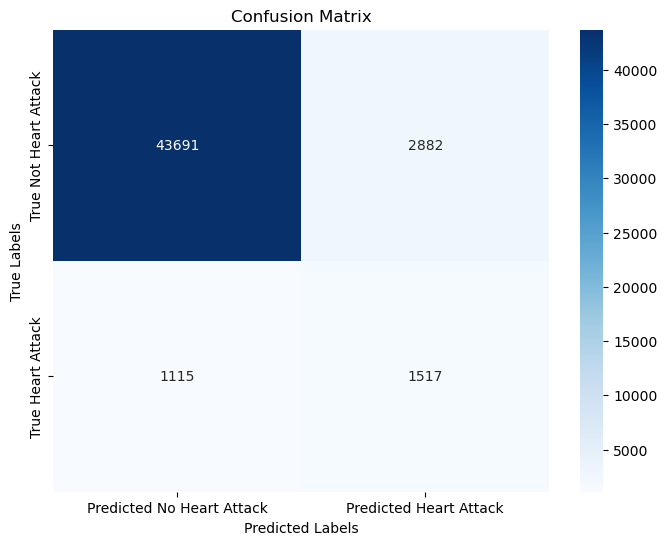

In [20]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Heart Attack', 'Predicted Heart Attack'], 
            yticklabels=['True Not Heart Attack', 'True Heart Attack'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
class_report = classification_report(y_test, y_pred, labels=[1, 0])
print(class_report)

              precision    recall  f1-score   support

           1       0.34      0.58      0.43      2632
           0       0.98      0.94      0.96     46573

    accuracy                           0.92     49205
   macro avg       0.66      0.76      0.69     49205
weighted avg       0.94      0.92      0.93     49205



In [22]:
plot(Effect(focal.predictors = c("PhysicalHealthDays"),
            mod = model))

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3825648352.py, line 1)

In [ ]:
feature_importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(feature_importance)

In [ ]:
odds_ratios = np.exp(model.coef_[0])
print(pd.Series(odds_ratios, index=X.columns).sort_values(ascending=False))

In [ ]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Identify highly correlated features
high_corr_var = np.where(corr_matrix > 0.4)  # Adjust threshold as needed
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y]
print(high_corr_var)

In [ ]:
remove_corr_var_list = []
for var_pairs in high_corr_var:
    if abs(feature_importance[var_pairs[0]]) < abs(feature_importance[var_pairs[1]]):
        remove_corr_var_list.append(var_pairs[0])
    else:
        remove_corr_var_list.append(var_pairs[1])
print(remove_corr_var_list)

In [ ]:
index_names_list = feature_importance.index.tolist()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature Scaling and Encoding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize and train the logistic regression model
class_weights = {'Yes': 1, 'No': 10}  # Adjust weights as needed

# Initialize and train the model with class weights
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))

In [ ]:
class_report = classification_report(y_test, y_pred, labels=['Yes', 'No'])

In [ ]:
print(class_report)

In [ ]:
# Count occurrences including all expected values
counts = y.value_counts().reindex(['Yes', 'No'], fill_value=0)

print(counts[1]/(counts[0] + counts[1]))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Class 2', 'Class 2'], yticklabels=['Not Class 2', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()